In [2]:
import src
import imp
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


In [2]:
import imp
imp.reload(src.features.preprocessing)

<module 'src.features.preprocessing' from '/home/davidjamesfulton93/repos/predict_pv_yield/src/features/preprocessing.py'>

In [3]:
pv_metadata_df = src.data.load_pv.load_pv_metadata("~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_METADATA_FILEPATH)

In [4]:
pv_metadata_df.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,...,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary,x,y
system_id,,,,,,,,,,,,,,,,,,,,,
690,3.8kw of Power @ No3,3800,NaN,20,190,Phono Solar,1,4000,SMA Sunny Boy 4000,S,...,2010-12-01 00:00:00,52.087171,-0.263414,10,0,0,NaN,NaN,519080.191006,244623.301288
709,Grove Cottages,2460,RG4,12,205,Romag PowerGlaz SMT6(54)P,1,3000,SMA Sunny Boy 3000TL,SE,...,2010-09-28 00:00:00,51.485329,-0.967526,5,0,0,NaN,NaN,471786.316866,176769.072244
777,Underfell1,3420,NaN,18,190,Schuco MPE 190 MS 05,1,4000,SMA Sunny Boy 4000TL,SW,...,2010-10-29 00:00:00,54.197863,-2.938757,10,0,0,NaN,NaN,338853.840270,478417.935178
794,Roofline,3700,GU34,20,185,Sharp,1,4000,SMA,SE,...,2011-01-05 00:00:00,51.112485,-1.032715,5,0,0,NaN,NaN,467806.490433,135244.187025
973,number38,4000,WA11,16,250,Sungrid/SG250M6,1,3800,Sunny Boy 3800,SW,...,2011-01-13 00:00:00,53.467927,-2.675806,5,0,0,NaN,NaN,355234.617987,397009.685712


In [5]:
pv_power_df = src.data.load_pv.load_pv_power(filepath="~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_DATA_FILEPATH, start='2018-01-01', end='2019-12-31')

In [6]:
pv_power_df = pv_power_df.dropna(axis=0, how='all')

In [7]:
pv_power_df.head()

,690,709,794,973,1364,1556,1627,1646,1647,1872,...,68000,68212,68218,68219,68303,68324,68404,68443,68800,68846
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop systems (in-place) without PV data and metadata
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [9]:
# make clearsky GHI object
latitude, longitude = pv_metadata_df.loc[pv_power_df.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude, g0=10)

# filter data to daylight hours (in-place)
ghiscalar.filter_to_daylight(pv_power_df, min_ghi=5, inplace=True)

In [10]:
# drop rows systems with no daylight
pv_power_df = pv_power_df.dropna(axis=0, how='all')
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [11]:
# scale by max power output
rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_df = rminmax.fit_transform(pv_power_df)

In [12]:
y_train_time, y_test_time = src.features.preprocessing.train_test_split_day(pv_prop_max_df, 0.2, shuffle=True, seed=9321749)

from sklearn.model_selection import train_test_split
train_columns, test_columns= train_test_split(pv_prop_max_df.columns, test_size=0.2, random_state=87321)

# different systems and different times
y_train = y_train_time.reindex(columns=train_columns, copy=False)
y_test_systemtime = y_test_time.reindex(columns=test_columns, copy=False)

In [13]:
src.data.sat_loader.AVAILABLE_CHANNELS

,description
channel_name,
VIS006,"λ_central=0.635µm, λ_min=0.56µm, λ_max=0.71µm,..."
VIS008,"λ_central=0.81µm, λ_min=0.74µm, λ_max=0.88µm, ..."
IR_016,"λ_central=1.64µm, λ_min=1.50µm, λ_max=1.78µm, ..."
IR_039,"λ_central=3.90µm, λ_min=3.48µm, λ_max=4.36µm, ..."
WV_062,"λ_central=6.25µm, λ_min=5.35µm, λ_max=7.15µm, ..."
WV_073,"λ_central=7.35µm, λ_min=6.85µm, λ_max=7.85µm, ..."
IR_087,"λ_central=8.70µm, λ_min=8.30µm, λ_max=9.1µm, |..."
IR_097,"λ_central=9.66µm, λ_min=9.38µm, λ_max=9.94µm, ..."
IR_108,"λ_central=10.80µm, λ_min=9.80µm, λ_max=11.80µm..."


In [14]:
sat_channels = src.data.sat_loader.DEFAULT_CHANNELS
sat_channels

['VIS006',
 'VIS008',
 'IR_016',
 'IR_039',
 'WV_062',
 'WV_073',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'HRV']

In [15]:
satloader = src.data.sat_loader.SatelliteLoader(height=144000, width=144000, channels=sat_channels)

In [16]:
src.data.nwp_loader.AVAILABLE_CHANNELS

,description
channel_name,
t,1.5m air temperature at surface
r,1.5m Relative humidity
dpt,1.5m dew point temperature
vis,1.5m visibility
si10,10m wind speed
wdir10,10m wind direction
prmsl,Mean sea level pressure
unknown_1,Uncertain. This is likely '1.5m fog probability'
unknown_2,Uncertain. This is likely 'snow fraction'


In [17]:
nwp_channels = ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf', 'si10', 'wdir10']

In [18]:
nwploader = src.data.nwp_loader.NWPLoader(height=144000, width=144000, time_slice=[0,1,2], channels=nwp_channels)

In [19]:
y_meta_train = pv_metadata_df.reindex(y_train.columns, copy=False)

In [20]:
# Do some nowcasting with sat only
batch_generator = src.data.batch_loader.cross_processor_batch(
            y_train, 
            y_meta_train, 
            y_index_sequence=[0,1,2,3,4,5,6,7,8,9,10,11,12],
            max_missing_sequence_vals=4,
            clearsky=None,
            sat_loader=satloader,
            nwp_loader=nwploader,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=256, 
            batches_per_superbatch=100, 
            n_superbatches=None, 
            n_epochs=1, 
            gpu=1,
            samples_per_datetime=100,
            parallel_loading_cores=1)

In [21]:
test_batch_generator = src.data.batch_loader.cross_processor_batch(
            y_test_systemtime, 
            pv_metadata_df.reindex(y_test_systemtime.columns, copy=False), 
            y_index_sequence=[0,1,2,3,4,5,6,7,8,9,10,11,12],
            clearsky=None,
            sat_loader=satloader,
            nwp_loader=nwploader,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=1000, 
            batches_per_superbatch=1, 
            n_superbatches=1, 
            n_epochs=None, 
            gpu=1,
            samples_per_datetime=1,
            parallel_loading_cores=1)

%time test_batch = next(test_batch_generator)

CPU times: user 34min 7s, sys: 4min 33s, total: 38min 40s
Wall time: 27min 43s


In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch

In [23]:
def conv_output_size(H_in, kernel_size, padding, dilation, stride):
    return int((H_in+2*padding - dilation * (kernel_size-1)-1)/stride + 1)

def times_to_channels(x):
    return torch.cat(torch.unbind(x, dim=-1), dim=1)

# modification of version from notebook 006. Now with fraction-of-year and lat-lon
class Net(nn.Module):
    def __init__(self, net_sat_channels, 
                 net_nwp_channels, 
                 conv_hidden_units,
                 image_side_length = 72,
                 include_tod=True, 
                 include_toy=False, 
                 include_latlon=False,
                 conv_kernel_size=5, 
                 fc_hidden_units=[1], 
                 conv_batchnorm=False,
                 fc_batchnorm=False,
                 activation=nn.LeakyReLU(),
                 output_activation=F.relu,
                 dropout_frac=0.):
        
        self.config = dict(
                 net_sat_channels=net_sat_channels, 
                 net_nwp_channels=net_nwp_channels, 
                 conv_hidden_units=conv_hidden_units,
                 image_side_length=image_side_length,
                 include_tod=include_tod,
                 include_toy=include_toy,
                 include_latlon=include_latlon,
                 conv_kernel_size=conv_kernel_size, 
                 fc_hidden_units=fc_hidden_units, 
                 conv_batchnorm=conv_batchnorm,
                 fc_batchnorm=fc_batchnorm,
                 activation=str(activation),
                 output_activation=str(output_activation),
                 dropout_frac=dropout_frac
        )
        
        super(Net, self).__init__()
        
        self.conv_hidden_units = conv_hidden_units
        self.conv_batchnorm = conv_batchnorm
        
        self.fc_hidden_units = fc_hidden_units
        self.fc_batchnorm = fc_batchnorm
        
        self.dropout_frac = dropout_frac
        self.activation = activation
        self.output_activation = output_activation
        
        self.include_tod = include_tod
        self.include_toy = include_toy
        self.include_latlon = include_latlon

        # set up convolutional layers
        if len(conv_hidden_units)>0:
            self.convs = [nn.Conv2d(in_channels=len(net_sat_channels)+len(net_nwp_channels)*3, 
                                    out_channels=self.conv_hidden_units[0],
                                    kernel_size=conv_kernel_size)]
            self.convs.extend([nn.Conv2d(in_channels=self.conv_hidden_units[i-1], 
                                    out_channels=self.conv_hidden_units[i],
                                    kernel_size=conv_kernel_size)
                         for i in range(1,len(self.conv_hidden_units))])
        
        #  set up convolutional batch-norms
        if conv_batchnorm:
            self.conv_norm = [nn.BatchNorm2d(c) for c in conv_hidden_units]
        
        # keep track of convolutional image size
        self.image_sizes = [image_side_length]
        for i in range(len(conv_hidden_units)):
            self.image_sizes.append(conv_output_size(self.image_sizes[-1], conv_kernel_size, 0, 1, 1))
        
        # set up fully connected layers
        if len(fc_hidden_units)>0:
            # calculate the zeroth number of nodes
            h0 = self.image_sizes[-1]**2*self.conv_hidden_units[-1]

            h0 += include_tod + include_toy + 2*include_latlon
            self.fc = [nn.Linear(h0, fc_hidden_units[0])] 
            self.fc.extend([nn.Linear(fc_hidden_units[i-1], fc_hidden_units[i]) for i in range(1,len(fc_hidden_units))])
            
        # set up convolutional batch norms
        if fc_batchnorm:
            self.fc_norm = [nn.BatchNorm1d(h) for h in fc_hidden_units]
        
        
        if dropout_frac>0:
            self.dropout = nn.Dropout(p=dropout_frac)
            
        # compile layers
        l = []
        if len(conv_hidden_units)>0: l+=self.convs
        if conv_batchnorm:           l+= self.conv_norm
        if len(fc_hidden_units)>0:   l+=self.fc
        if fc_batchnorm:             l+=self.fc_norm
        
        self.module_list = nn.ModuleList(l)


    def forward(self, batch):

        x = torch.cat((batch['satellite'], batch['nwp']), dim=1)

        for i in range(len(self.convs)):
            x = self.convs[i](x)
            if self.conv_batchnorm:
                x = self.conv_norm[i](x)
            if self.dropout_frac>0:
                x = self.dropout(x)
            x = self.activation(x)

        data = [x.view(x.shape[0], -1)]
            
        if self.include_tod: data.append(batch['day_fraction'].view(-1,1))
        if self.include_toy: data.append(batch['year_fraction'].view(-1,1))
        if self.include_latlon: data.append(batch['latlon'].view(-1,2))

        if len(data)>1:
            x = torch.cat(data, dim=1)
        else:
            x = data[0]

        for i in range(len(self.fc)):
            x = self.fc[i](x)
            if i!=len(self.fc)-1:
                if self.conv_batchnorm:
                    x = self.fc_norm[i](x)
                if self.dropout_frac>0:
                    x = self.dropout(x)
                x = self.activation(x)
                
        x = self.output_activation(x)
        
        return x

In [24]:
def torch_nan_mse(ypred, y):
    mask = ~torch.isnan(y)
    dy2 = (y[mask]-ypred[mask])**2
    return dy2.mean()

def torch_nan_mae(ypred, y):
    mask = ~torch.isnan(y)
    dy = torch.abs(y[mask]-ypred[mask])
    return dy.mean()

In [25]:
# Up to 4/13 y-values in each target sequence are NaN,
# loss functions must accept this
MSE_LOSS_FUNC = torch_nan_mse
MAE_LOSS_FUNC = torch_nan_mae

In [26]:
import json

MODEL_DUMP_ROOT = os.path.expanduser('~/model_dump/010')

class net_container:
    def __init__(self, net, optimizer, loss_func=nn.MSELoss(), run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        
        self.running_train_loss = 0
        self.running_train_mse = 0
        self.running_train_mae = 0
        
        self.train_losses = []
        self.train_mse_losses = []
        self.train_mae_losses = []
        
        self.test_losses = []
        self.test_mse_losses = []
        self.test_mae_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, batch, batch_number):
        
        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net(batch)
        train_loss = self.loss_func(outputs, batch['y'])
        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()
        
        # MAE
        train_mae = MAE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mae += train_mae.item()
        
        # MSE
        train_mse = MSE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mse += train_mse.item()

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                mean_train_mse = self.running_train_mse
                mean_train_mae = self.running_train_mae
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD
                mean_train_mse = self.running_train_mse / STATS_PERIOD
                mean_train_mae = self.running_train_mae / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            self.train_mse_losses.append(mean_train_mse)
            self.train_mae_losses.append(mean_train_mae)
            
            self.running_train_loss = 0.
            self.running_train_mse = 0.
            self.running_train_mae = 0.

            # Test loss
            self.net.eval()
            test_outputs = self.net(test_batch)
            
            test_loss = self.loss_func(test_outputs, test_batch['y']).item()
            self.test_losses.append(test_loss)
            test_mae = MAE_LOSS_FUNC(test_outputs, test_batch['y']).item()
            self.test_mae_losses.append(test_mae)
            test_mse = MSE_LOSS_FUNC(test_outputs, test_batch['y']).item()
            self.test_mse_losses.append(test_mse)
            
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(os.path.join(thisdir, "figures"))
                    
                    with open(os.path.join(thisdir, 'config.json'), 'w') as f:
                        json.dump(self.net.config, f, indent=4)
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'train_mse':self.train_mse_losses,
                    'train_mae':self.train_mae_losses,
                    'test_loss':self.test_losses,
                    'test_mse':self.test_mse_losses,
                    'test_mae':self.test_mae_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))
                    

In [27]:
smaller_net = Net(
           sat_channels, 
           nwp_channels, 
           include_tod=True,
           include_toy=True, 
           include_latlon=False,
           conv_hidden_units=[20, 20],
           image_side_length=72,
           conv_kernel_size=10,
           fc_hidden_units=[20,20,13],
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
    ).cuda().half()



medium_net = Net(
           sat_channels, 
           nwp_channels, 
           include_tod=True,
           include_toy=True, 
           include_latlon=False,
           conv_hidden_units=[100, 100, 50, 20],
           image_side_length=72,
           conv_kernel_size=10,
           fc_hidden_units=[100, 100, 20, 13],
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
    ).cuda().half()


bigger_net = Net(
           sat_channels, 
           nwp_channels, 
           include_tod=True,
           include_toy=True, 
           include_latlon=False,
           conv_hidden_units=[100, 200, 200, 100, 70, 50],
           image_side_length=72,
           conv_kernel_size=10,
           fc_hidden_units=[200, 200, 100, 50, 13],
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
    ).cuda().half()


In [28]:
def sgd_training_container(net, name):
    return net_container(
        net,
        optimizer=optim.SGD(net.parameters(), lr=0.01, momentum=0.8), 
        loss_func=MSE_LOSS_FUNC,
        run_name=name,
    )

In [29]:
smaller_container = sgd_training_container(smaller_net, 'small_hybrid')
medium_container = sgd_training_container(medium_net, 'medium_hybrid')
bigger_container = sgd_training_container(bigger_net, 'big_hybrid')

In [30]:
containers = [smaller_container, medium_container, bigger_container]

In [31]:
STATS_PERIOD = 100

In [32]:
def modify_batch(batch, inplace=False):
    if inplace:
        for k,v in batch.items():
            if k=='y':
                continue
            elif k=='nwp':
                batch[k] = times_to_channels(v)
            else:
                batch[k] = v[...,0]
        return batch
    else:
        mod_batch = {}
        for k,v in batch.items():
            if k=='y':
                mod_batch[k] = v
            elif k=='nwp':
                mod_batch[k] = times_to_channels(v)
            else:
                mod_batch[k] = v[...,0]
        return mod_batch

In [33]:
test_batch = modify_batch(test_batch, inplace=True)

In [34]:
batch = next(batch_generator)

In [35]:
batch_generator.batch_index=0

In [37]:
shuffles_per_superbatch = 4
current_shuffles = 1

for i_batch, batch in enumerate(batch_generator):
    
    batch = modify_batch(batch)
    
    for container in containers:
        print(f'batch:{i_batch:03} | {container.run_name:30s}\r', end="")
        container.train_step(batch, i_batch)
        
    # if we have got to end of superbatch reshuffle
    if batch_generator.batch_index==(batch_generator.batches_per_superbatch-1):
        # but only if we haven't already shuffled so mnay times
        if current_shuffles < shuffles_per_superbatch:
            batch_generator.shuffle_cpu_superbatch()
            if batch_generator.gpu==2: batch_generator.transfer_superbatch_to_gpu()
            batch_generator.batch_index = 0
            current_shuffles+=1
        # if we have shiuffled our limit of times then update shuffle tally
        elif current_shuffles >= shuffles_per_superbatch:
            print(f'batch:{i_batch} - reshuffled this super-batch too many times. Loading new.\r', end="")
            current_shuffles = 1


print('\nFinished Training')

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [39]:
import glob
model_dumps = [x.split('/')[-1] for x in glob.glob(os.path.expanduser('~/model_dump/010/*')) if not x.endswith('ipynb')]
#model_dumps = [x for x in model_dumps if '1' not in x]

In [40]:
dfs = [pd.read_csv(f'~/model_dump/010/{model}/training_stats.csv', ).set_index('batch')\
       for model in model_dumps]

Note I stopped the medium sized network early

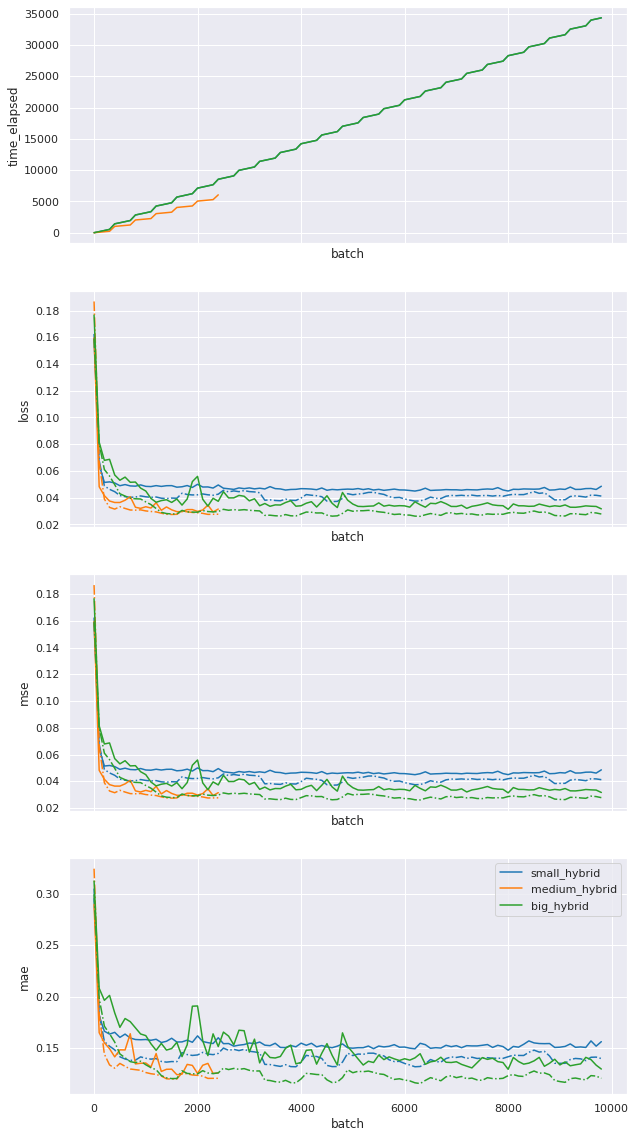

In [41]:
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
sns.set()


fig, axes = plt.subplots(4,1, sharex=True, figsize=(10,20))
axes = axes.flatten()
plot_metrics = ['time_elapsed', 'loss', 'mse', 'mae']

for ax, metric in zip(axes, plot_metrics):
    colors = cycle(prop_cycle.by_key()['color'])
    
    for i in range(len(model_dumps)):
        c = next(colors)
        df_ = dfs[i].rolling(1).mean()#.loc[2:]
        if metric=='time_elapsed':
            ax.plot(df_.index, df_[metric], label=model_dumps[i], color=c)
        else:
            ax.plot(df_.index, df_['train_'+metric], linestyle='-.', color=c)
            ax.plot(df_.index, df_['test_'+metric], linestyle='-', label=model_dumps[i], color=c)
    ax.set_xlabel('batch')
    ax.set_ylabel(metric)
ax.legend()
plt.show()

In [126]:
final_results_df = {}
for i,model in enumerate(model_dumps):
    df = dfs[i].iloc[-1:].mean()
    for ind in df.index:
        if ind in final_results_df.keys():
            final_results_df[ind].append(df[ind])
        else:
            final_results_df[ind] = [df[ind]]
pd.DataFrame(final_results_df, index=model_dumps).sort_values('test_loss').drop(['Unnamed: 0','train_loss','test_loss' ], axis=1)

,time_elapsed,train_mse,train_mae,test_mse,test_mae
medium_hybrid,6053.194796,0.027675,0.120892,0.031525,0.126099
big_hybrid,34355.030043,0.027804,0.120845,0.031677,0.129883
small_hybrid,34352.462374,0.041242,0.140067,0.048584,0.156494


Been having some cuda memory errors so move nets to cpu for simplicity

In [72]:
bigger_net_cpu = bigger_net.cpu().float()
smaller_net_cpu = smaller_net.cpu().float()

In [113]:
medium_net = torch.load(os.path.join(MODEL_DUMP_ROOT, 'medium_hybrid', 'best_model.pkl'))
medium_net_cpu = medium_net.cpu().float()

In [73]:
test_batch_cpu = {k:v[:200].cpu().float() for k,v in test_batch.items()}

In [74]:
bigger_output_cpu = bigger_net_cpu(test_batch_cpu)

In [114]:
medium_output_cpu = medium_net_cpu(test_batch_cpu)

In [91]:
smaller_output_cpu = smaller_net_cpu(test_batch_cpu)

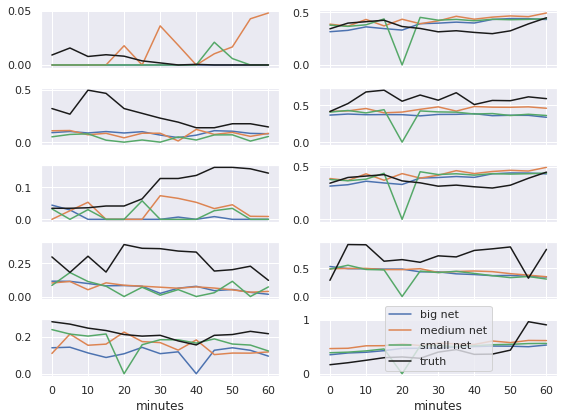

In [122]:
n = 10
np.random.seed(619)
cs = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

inds = np.random.randint(0, len(bigger_output_cpu), n)

fig, axes = plt.subplots(5,2, figsize=(8,6), sharex=True)
axes[4,0].set_xlabel('minutes')
axes[4,1].set_xlabel('minutes')

axes = axes.flatten()

x = np.arange(0, 65, 5)
for i, ind in enumerate(inds):
    axes[i].plot(x, bigger_output_cpu[ind].detach().numpy(), color=cs[0],  label='big net') #linestyle='--',
    axes[i].plot(x, medium_output_cpu[ind].detach().numpy(), color=cs[1],  label='medium net') #linestyle=':',
    axes[i].plot(x, smaller_output_cpu[ind].detach().numpy(), color=cs[2],  label='small net') #linestyle='-.',
    axes[i].plot(x, test_batch_cpu['y'][ind].detach().numpy(), color='k', label='truth')

axes[i].legend()
plt.tight_layout()
plt.savefig("sequence_predictions.png")
plt.show()